# 誤差逆伝播法
ニューラルネットワークの重みパラメータの勾配を効率よく計算するための手法\
出力層側から入力層側へデータを送ることで勾配を求める\
計算グラフを用いて求めていく

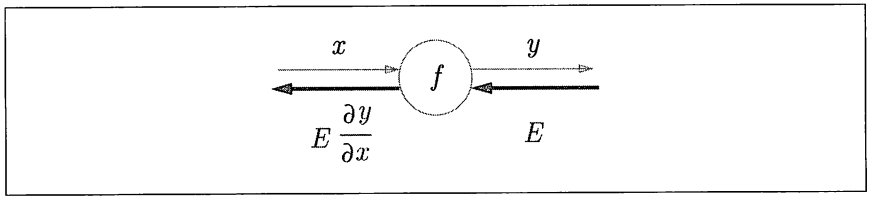

# 計算グラフ
計算グラフとは、計算の過程をグラフによって表したもの\
複数のノードとエッジによって構成され、ノードで演算を表し、演算結果を他のノードへと渡す役割しているのがエッジ\
2つの問題を計算グラフで表してみる\
\
問1：1個100円のリンゴを2個買いました。支払う金額を求めなさい。ただし、消費税が10％適用されるものとする

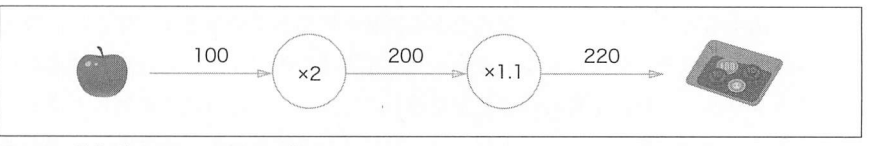

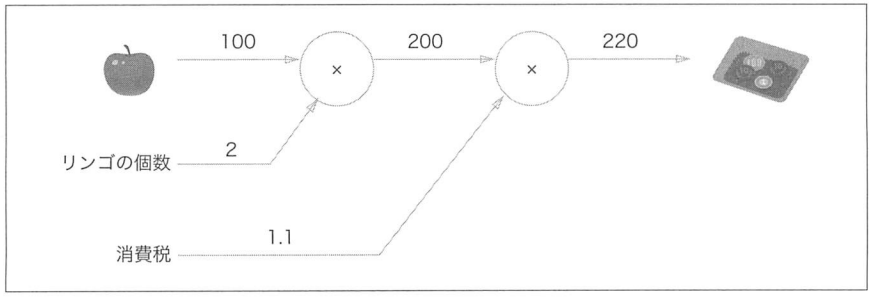

問2：リンゴを2個、みかんを3個買いました。リンゴは1個100円、みかんは1個150円です。消費税が10％かかるものとし支払う金額を求めなさい。

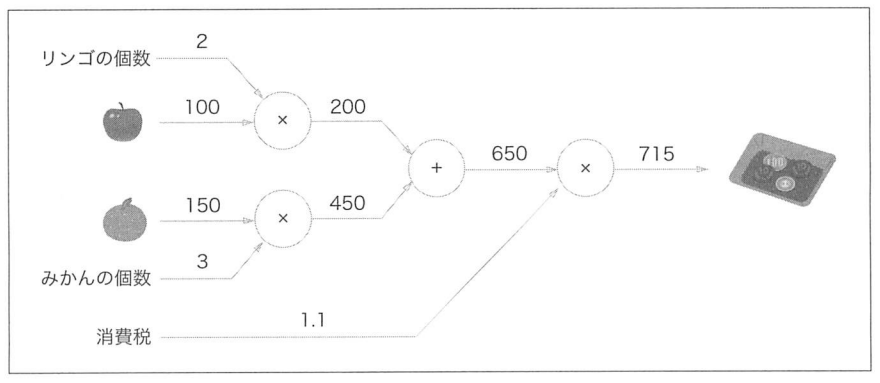

このように計算グラフを使って問題を解くには、\
１．計算グラフを構築する\
２．計算グラフ上で計算を左から右へ進める\
という流れで行う。\
左から右へ計算を進めていくことを順伝播といい、右から左へ計算を進めていくことを逆伝播という。\
逆伝播は微分を計算するうえで重要な働きをする。


# 連鎖律

連鎖律とは合成関数の微分についての性質であり、次のように定義される\
\
    「ある関数が合成関数で表される場合、その合成関数の微分は、合成関数を構成する\
    それぞれの関数の微分の積によってあらわすことが出来る。」\
\
つまり、\
$$
\frac{∂z}{∂x}=\frac{∂z}{∂t}\frac{∂t}{∂x}
$$

# 逆伝播

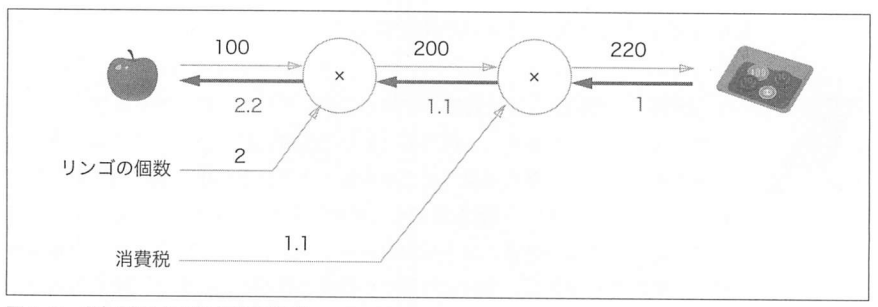

計算グラフにおける逆伝播は、「局所的な微分」を表す。\
問１のリンゴの価格が1円値上がりした場合、最終的な支払金額どの程度影響があるのかを調べる。\
この場合、1を出力側から伝播させることで求められ、局所的な微分の積である2.2がリンゴの価格がによる支払金額の微分値として求められる。

①加算ノードの逆伝播\
\
z=x+yを行うノードの逆伝播を考える。
$$
\frac{∂z}{∂x}=1
$$
\
$$
\frac{∂z}{∂y}=1
$$
なので、

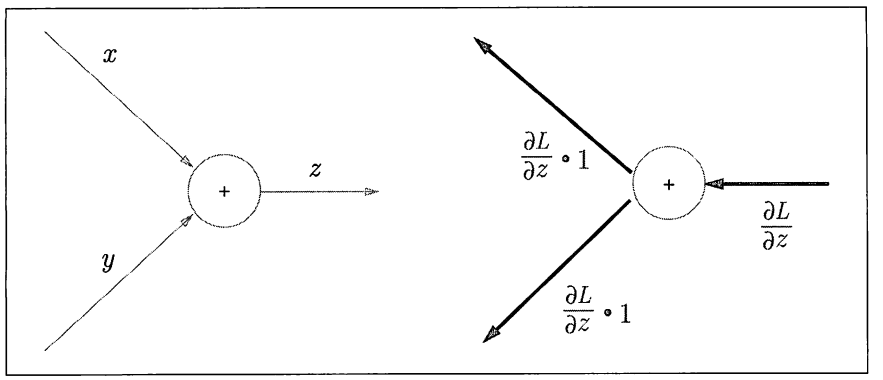

$
\frac{∂L}{∂x}=1.3
$
とすると、

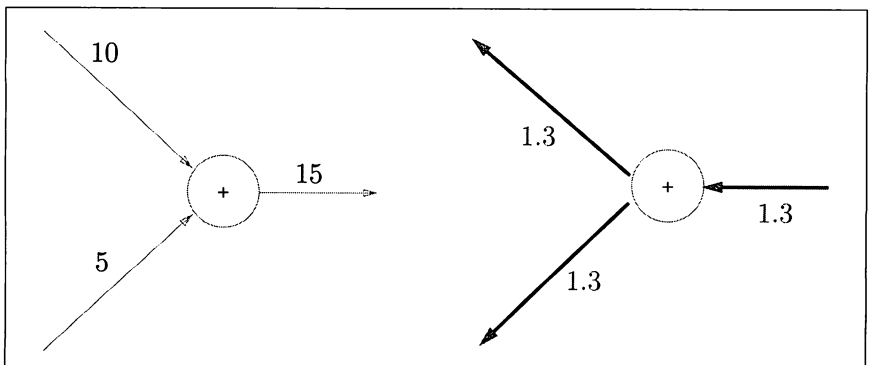

②乗算ノードの逆伝播\
\
z=x＊yを行うノードの逆伝播を考える。
$$
\frac{∂z}{∂x}=y
$$
\
$$
\frac{∂z}{∂y}=x
$$
なので、

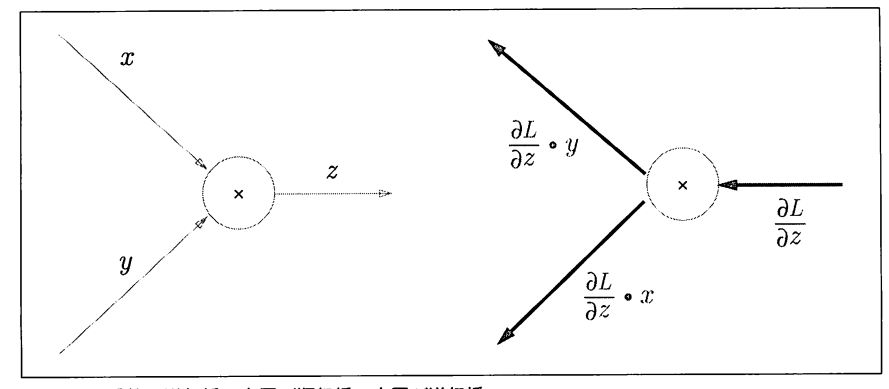
$
\frac{∂L}{∂x}=1.3
$
とすると、

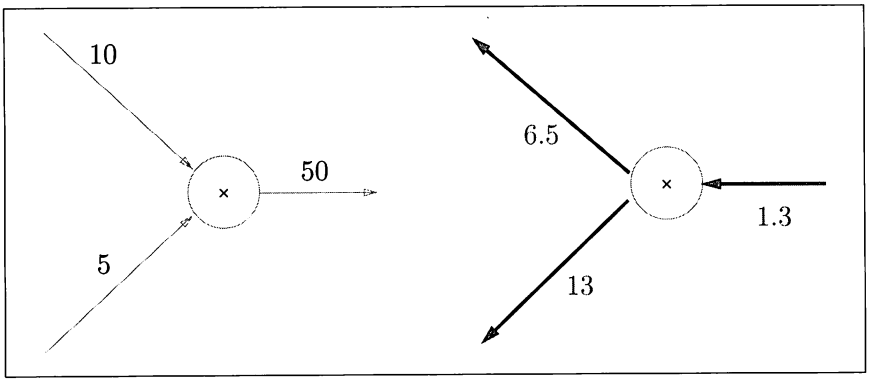

# レイヤの実装

①乗算レイヤ

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

問1の実装\
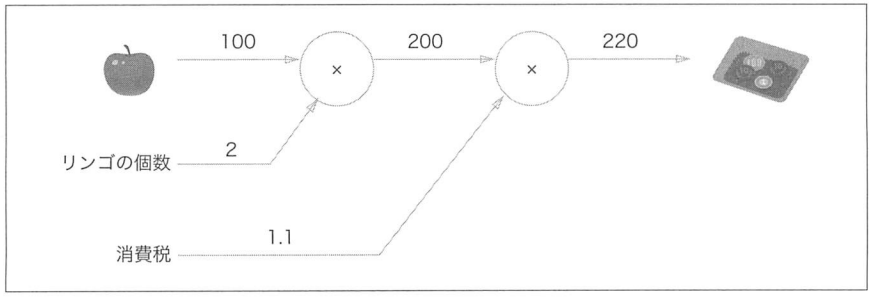

In [2]:
# coding: utf-8
from layer_naive import *


apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


②加算レイヤ

In [3]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

問2の実装\
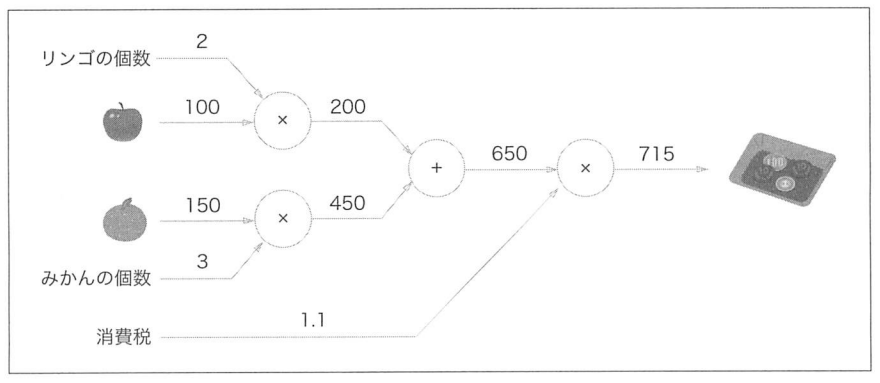

In [4]:
from layer_naive import *

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


③ReLUレイヤ

$
    y=
        \begin{cases}
            x \quad x > 0 \\
            0 \quad x \leqq 0\\
        \end{cases}
$
\
より、\
$
    \frac{∂y}{∂x}=
        \begin{cases}
            1 \quad x > 0 \\
            0 \quad x \leqq 0\\
        \end{cases}
$

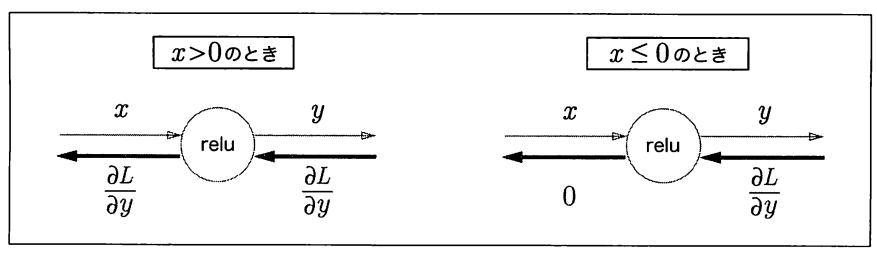

In [5]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

④Sigmoidレイヤ\
$$
y=\frac{1}{1+\exp(-x)}
$$

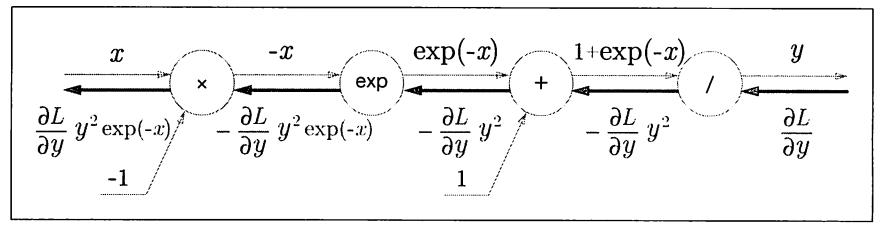

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

⑤Affineレイヤ\
重み付き信号の総和を計算するレイヤ

In [7]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

⑥Softmax-with-lossレイヤ\
入力信号の総和が１になるように正規化するレイヤ\
出力層に使われる

In [8]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

# 誤差逆伝播法の実装

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# 誤差逆伝播法の勾配確認
誤差逆伝播法と数値微分による勾配の値が近しいことを確認する作業

In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.999412778178249e-10
b1:2.258302229237396e-09
W2:6.368043006241015e-09
b2:1.3996160279639015e-07


# 誤差逆伝播法を使った学習

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.12586666666666665 0.1252
0.9038833333333334 0.9055
0.9226333333333333 0.9251
0.9374833333333333 0.9344
0.9463 0.9437
0.9517166666666667 0.9477
0.9557 0.9519
0.9610166666666666 0.9553
0.9635833333333333 0.9588
0.9648 0.9579
0.9690666666666666 0.9623
0.9714 0.9645
0.9731166666666666 0.966
0.9748 0.9668
0.9754666666666667 0.9667
0.9767833333333333 0.9687
0.9790666666666666 0.9697
